This notebook attempts rotation as implemented in [this Monai tutorial](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/master/modules/3d_image_transforms.ipynb#scrollTo=soJiHn_Wj6gy)

In [2]:
import matplotlib.pyplot as plt
import nibabel as nib
import nilearn as nil
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import os
import numpy as np
import monai

import torch
from torch.utils.data import DataLoader

from nibabel import save
from nilearn import image
from nilearn.image import get_data
from nilearn.plotting import show

from monai.transforms import (
    EnsureChannelFirstd,
    LoadImaged,
    BorderPadd,
    RandAffined,
    Affined,
    EnsureChannelFirstd,
    Compose,
    LoadImaged,
    SaveImaged,
    ScaleIntensityd,
)
from monai.config import print_config
from monai.apps import download_and_extract
from monai.utils import set_determinism, first

import os
import shutil
import glob as glob

print_config()

MONAI version: 1.2.0
Numpy version: 1.25.0
Pytorch version: 2.0.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: /home/chloe/.conda/envs/torch/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.3.0
Nibabel version: 5.1.0
scikit-image version: 0.20.0
Pillow version: 9.4.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.15.2
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.5.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://doc

Create dataset path and dictionary

In [3]:
data_dir = "data/"

train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTs", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTs", "*.nii.gz")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]

Load the iamges to visualize a sampling and get data dimensions

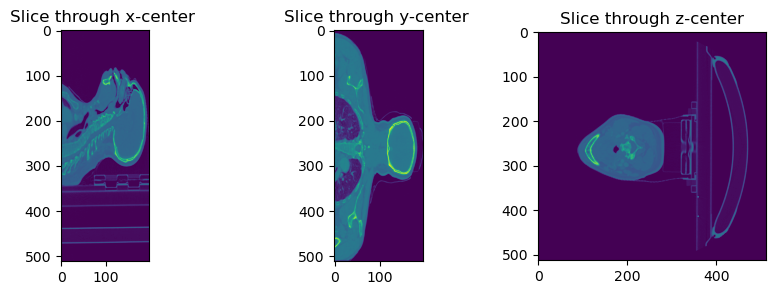

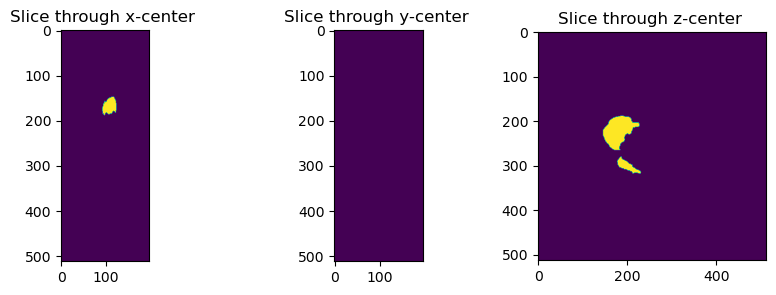

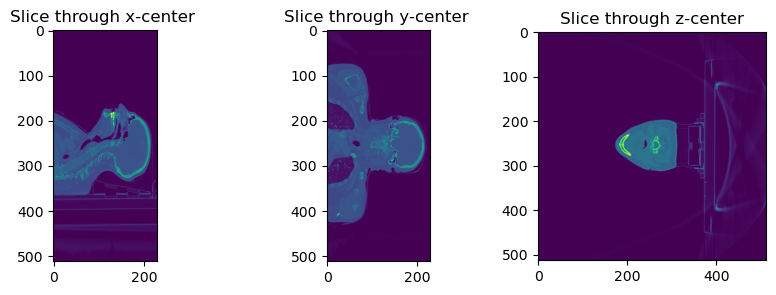

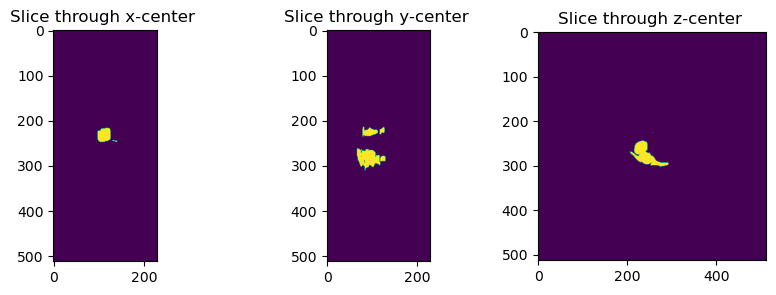

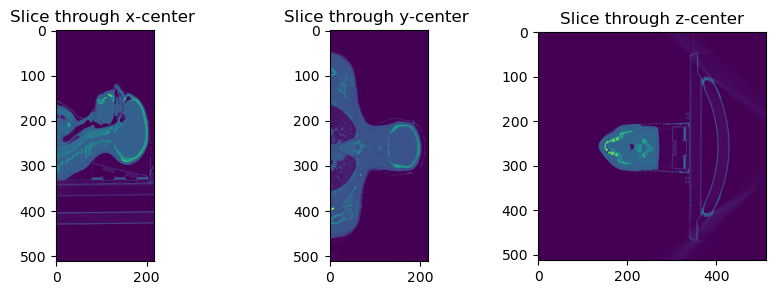

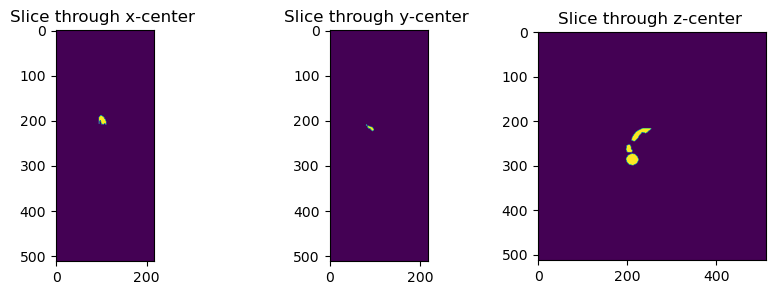

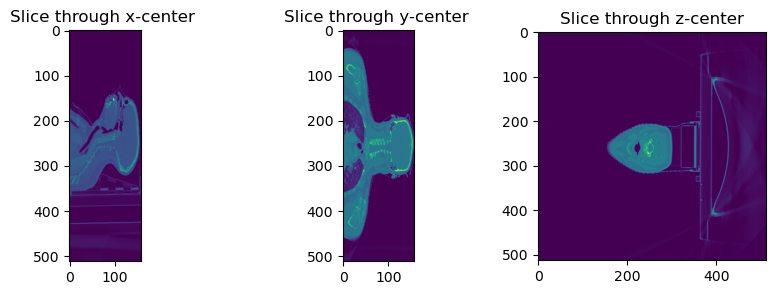

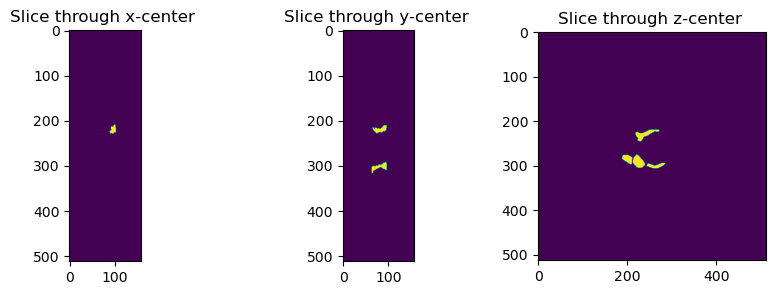

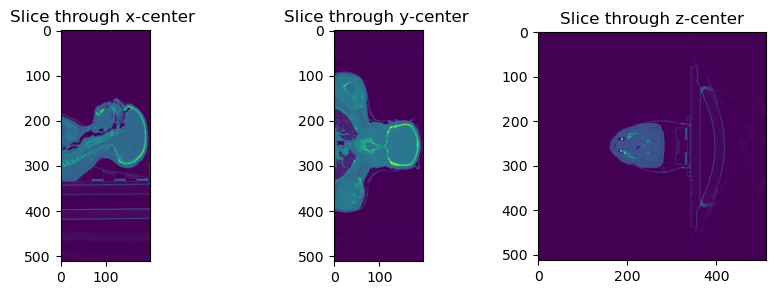

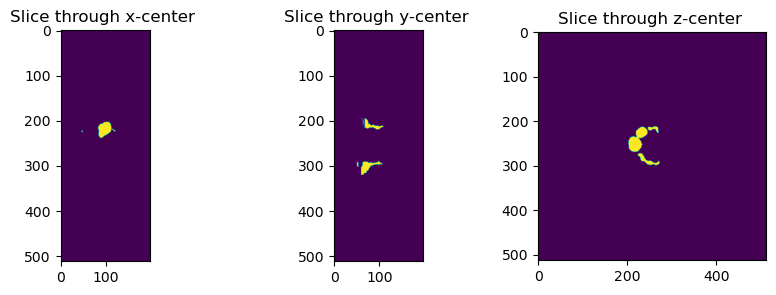

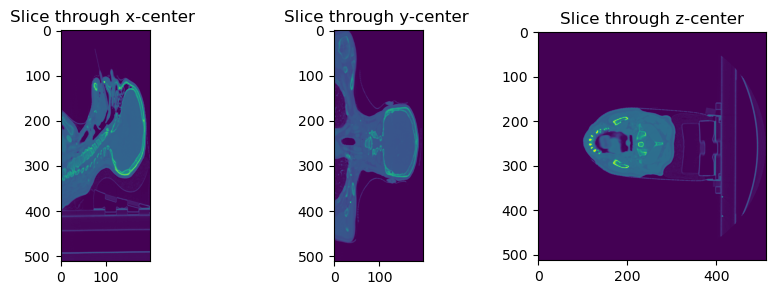

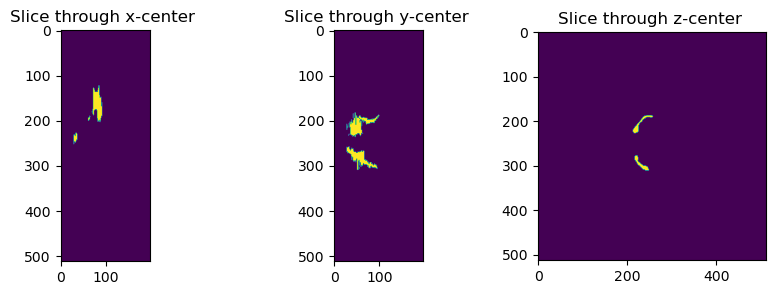

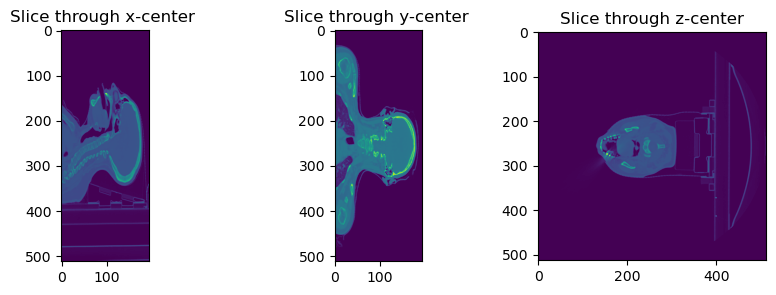

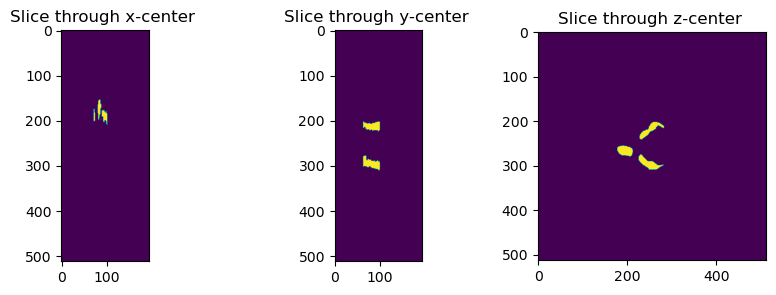

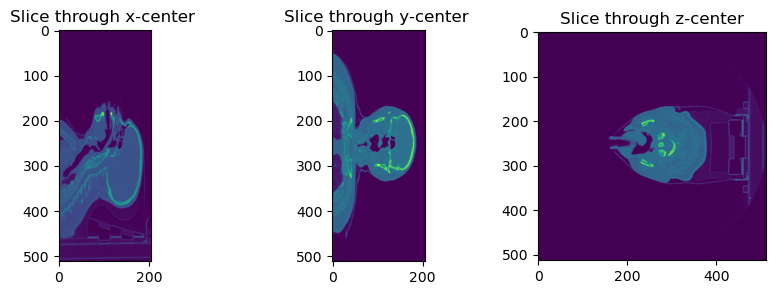

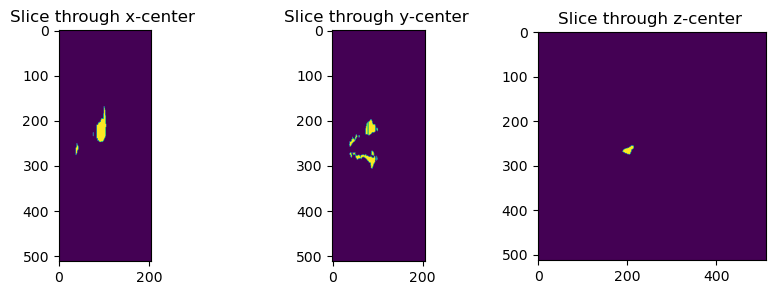

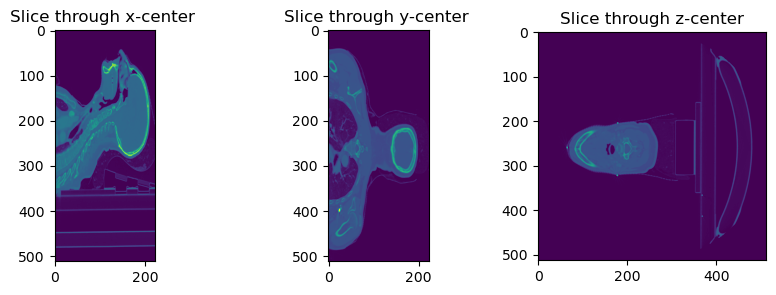

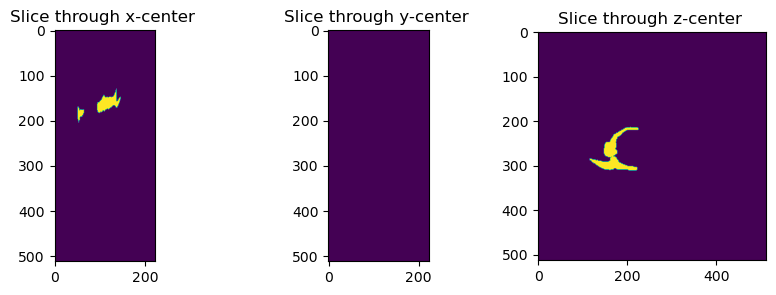

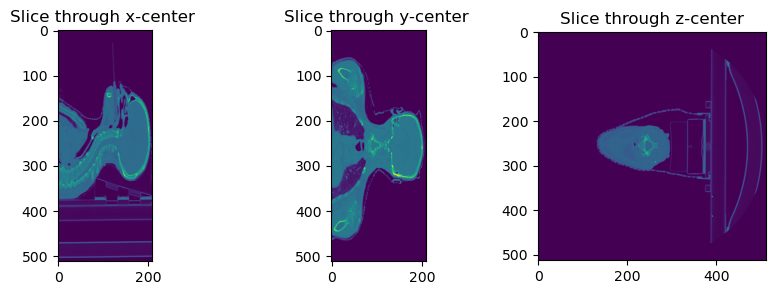

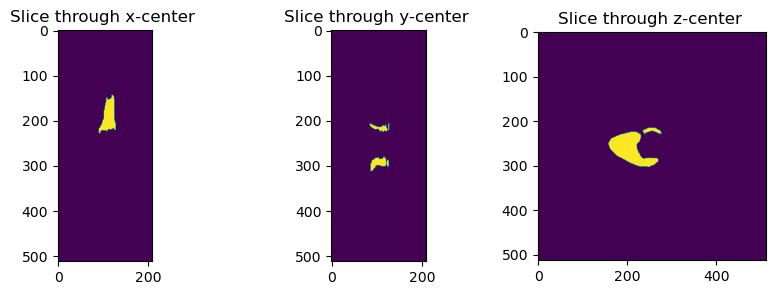

In [3]:
dimensions = np.zeros([len(data_dicts),3])

for index in range(len(data_dicts)):
    img_path = data_dicts[index]['image']
    lbl_path = data_dicts[index]['label']
    before_rot = image.load_img(img_path)
    before_rot_label = image.load_img(lbl_path)
    dimension = before_rot.shape
    dimensions[index] = dimension

    center = np.divide(dimension,2)
    x_cen = int(np.ceil(center[0]))
    y_cen = int(np.ceil(center[1]))
    z_cen = int(np.ceil(center[2]))

    fig = plt.figure("visualize", (len(data_dicts), 3))
    fig.set_size_inches(10,3)
    plt.subplot(1, 3, 1)
    plt.title(f"Slice through x-center ")
    plt.imshow(get_data(before_rot)[x_cen, :, :])
    plt.subplot(1, 3, 2)
    plt.title(f"Slice through y-center ")
    plt.imshow(get_data(before_rot)[:, y_cen, :])
    plt.subplot(1, 3, 3)
    plt.title(f"Slice through z-center")
    plt.imshow(get_data(before_rot)[:, :, z_cen])
    plt.show()

    fig = plt.figure("labels", (len(data_dicts), 3))
    fig.set_size_inches(10,3)
    plt.subplot(1, 3, 1)
    plt.title(f"Slice through x-center ")
    plt.imshow(get_data(before_rot_label)[x_cen, :, :])
    plt.subplot(1, 3, 2)
    plt.title(f"Slice through y-center ")
    plt.imshow(get_data(before_rot_label)[:, y_cen, :])
    plt.subplot(1, 3, 3)
    plt.title(f"Slice through z-center ")
    plt.imshow(get_data(before_rot_label)[:, :, z_cen])
    plt.show()
    

Visualize all the dimensions

In [4]:
print(dimensions)

[[512. 512. 196.]
 [512. 512. 229.]
 [512. 512. 217.]
 [512. 512. 158.]
 [512. 512. 197.]
 [512. 512. 197.]
 [512. 512. 194.]
 [512. 512. 205.]
 [512. 512. 223.]
 [512. 512. 209.]]


Set axis of rotation: 
- x = 0
- y = 1
- z = 2

Set starting degree, ending degree of rotation, and rotation step.

This code will produce rotations increaseing from starting degree to ending degree with step of chosen degree (ensure this divides evenly). 

In [5]:
axis = 2

start_deg = -180
end_deg = 180
step = 10

if (start_deg - end_deg)%step != 0:
    print("Step does not divide evenly: choose different rotation parameters.")

Loop over all rotations: Use get_dim_about_z notebook in order to get x,y dimensions using your maximum rotation. For rotations between -30 to 30 degrees, we have a maximum x and y dimension of 572.

In [6]:
set_dist = 722

deg_array = np.zeros(3)
deg_array[axis] = start_deg - step

#Loop over specified range of degrees
while deg_array[axis] < end_deg:

    #Set degree for iteration
    deg_array[axis] = deg_array[axis] + step
    deg_array_rad = np.deg2rad(deg_array)

    a, b, c = deg_array[0], deg_array[1], deg_array[2]
    a_rad, b_rad, c_rad = deg_array_rad[0], deg_array_rad[1], deg_array_rad[2]

    #Create folders to store rotated images and labels
    image_path = f'results/transformed_results/transformed_images/{a}_{b}_{c}' 
    if not os.path.exists(image_path):
        os.makedirs(image_path)

    label_path = f'results/transformed_results/transformed_labels/{a}_{b}_{c}' 
    if not os.path.exists(label_path):
        os.makedirs(label_path)

    #Produce rotated image with maximum padding for each image
    for index in range(len(data_dicts)):
        data_transform = Compose(
            [
                LoadImaged(keys=["image", "label"]),
                EnsureChannelFirstd(keys=["image", "label"]),
                BorderPadd(keys=["image"],
                        spatial_border = 1, 
                        mode='constant', 
                        lazy=False, 
                        constant_values = -1024),
                BorderPadd(keys=["label"],
                        spatial_border = 1, 
                        mode='constant', 
                        lazy=False,
                        constant_values = 0),
                Affined(keys=["image", "label"],
                    rotate_params = (a_rad, b_rad, c_rad),
                    mode=('bilinear','nearest'),
                    padding_mode=('border'),
                    spatial_size = (set_dist, set_dist, -1),
                    align_corners = True
                ),
                SaveImaged(keys=["image"],
                    output_dir=image_path, 
                    output_postfix =  f"rotated_image_{a}_{b}_{c}_0000",
                    output_ext=".nii.gz",
                    resample = False),
                SaveImaged(keys=["label"],
                    output_dir=label_path, 
                    output_postfix =  f"rotated_label_{a}_{b}_{c}",
                    output_ext=".nii.gz",
                    resample = False),
            ])

        #Runs transformation with specified shape
        transformed_data_dict = data_transform(data_dicts[index])
    



monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


2023-08-17 15:03:58,928 INFO image_writer.py:197 - writing: /home/chloe/research/code/inference_05/results/transformed_results/transformed_images/0.0_0.0_-180.0/HN_P002_pre_0000/HN_P002_pre_0000_rotated_image_0.0_0.0_-180.0_0000.nii.gz
2023-08-17 15:04:05,169 INFO image_writer.py:197 - writing: /home/chloe/research/code/inference_05/results/transformed_results/transformed_labels/0.0_0.0_-180.0/HN_P002_pre/HN_P002_pre_rotated_label_0.0_0.0_-180.0.nii.gz
2023-08-17 15:04:21,131 INFO image_writer.py:197 - writing: /home/chloe/research/code/inference_05/results/transformed_results/transformed_images/0.0_0.0_-180.0/HN_P003_pre_0000/HN_P003_pre_0000_rotated_image_0.0_0.0_-180.0_0000.nii.gz
2023-08-17 15:04:28,532 INFO image_writer.py:197 - writing: /home/chloe/research/code/inference_05/results/transformed_results/transformed_labels/0.0_0.0_-180.0/HN_P003_pre/HN_P003_pre_rotated_label_0.0_0.0_-180.0.nii.gz
2023-08-17 15:04:44,245 INFO image_writer.py:197 - writing: /home/chloe/research/code/

Copy rotated images into nnUnet folder for testing

In [7]:
# Define the path to where you store transformed data and where to store nnUnet data
transform_image_dir = '/results/transformed_results/transformed_images'
nnUnet_data_path = '/home/chloe/nnUNet_raw_data_base/nnUNet_raw_data/Task603_SettingUp/imagesTs' #Change to path for nnUnet data

# Code to move transformed data from subfolders to single folder
rot_list = os.listdir(transform_image_dir) 

for rot in rot_list:
    rot_path = os.path.join(transform_image_dir, rot)
    patient_names = os.listdir(rot_path)
    for patient in patient_names:
        patient_path = os.path.join(rot_path, patient)
        image_names = os.listdir(patient_path)
        for image in image_names:
            image_path = os.path.join(patient_path, image)
            shutil.copy(image_path, nnUnet_data_path)

print("Files copied")

Files copied


Visualize the max rotations

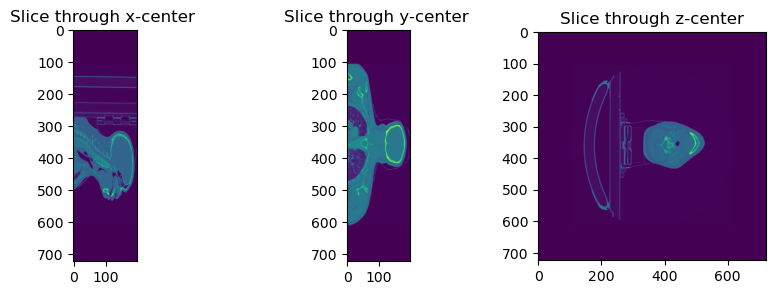

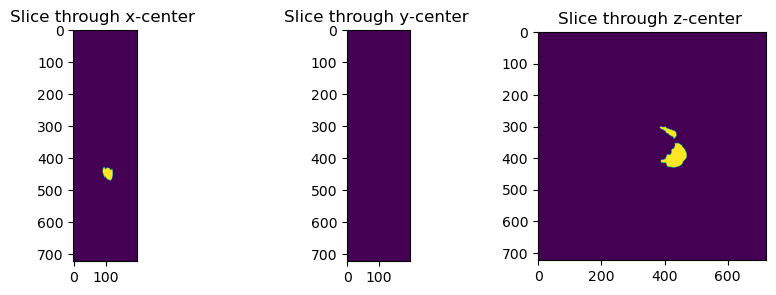

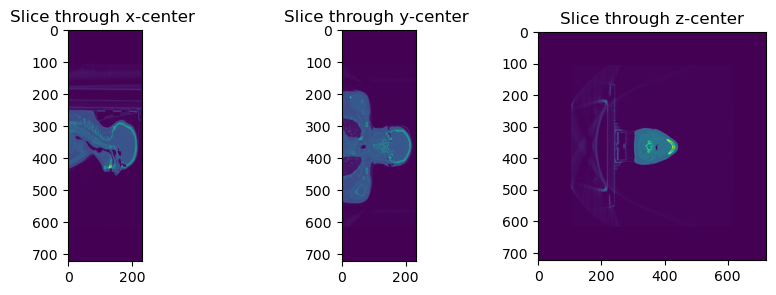

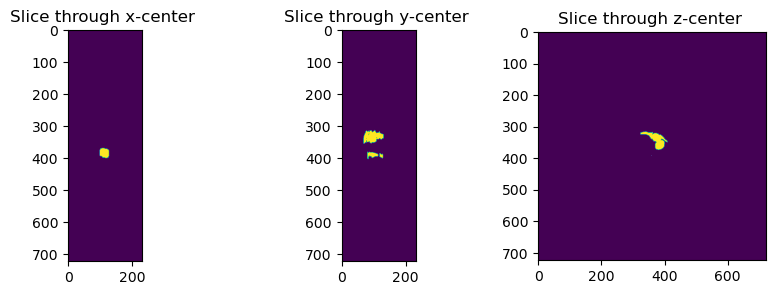

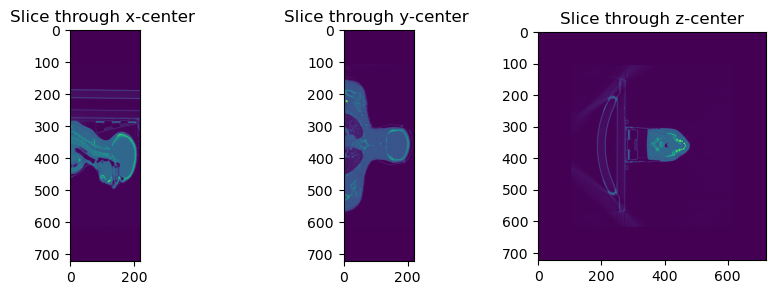

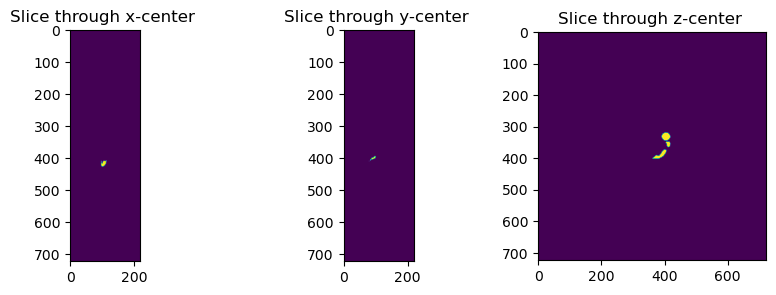

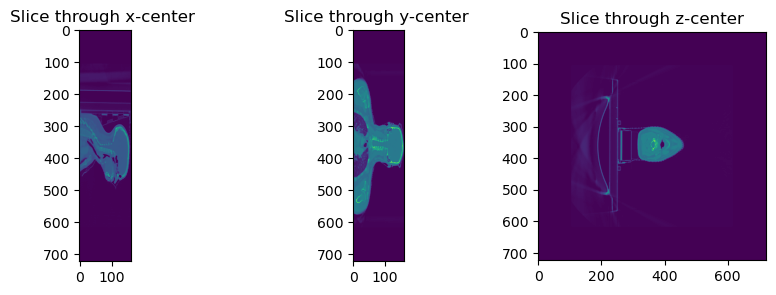

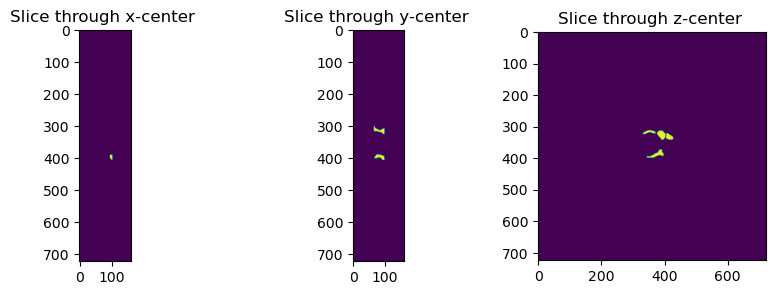

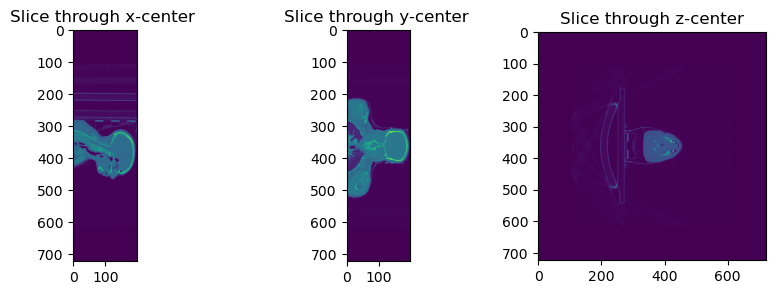

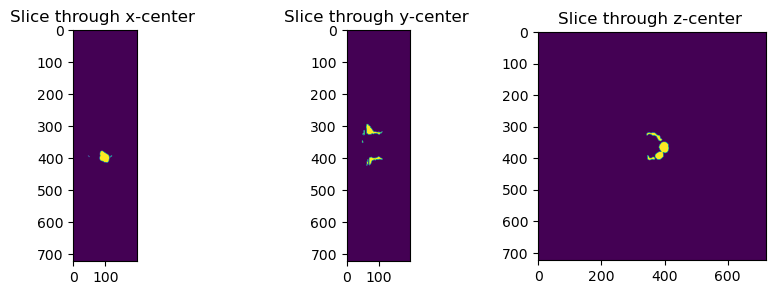

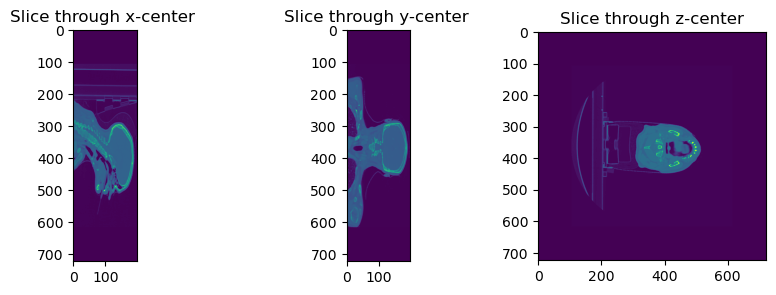

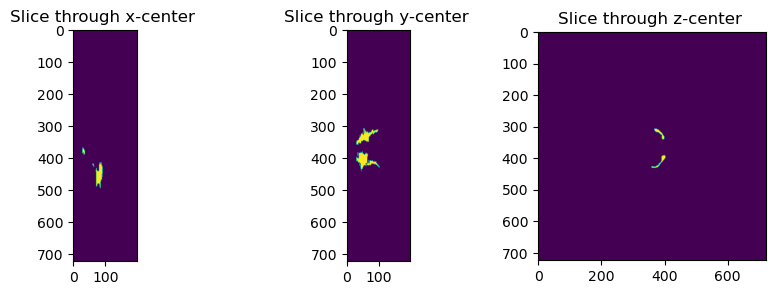

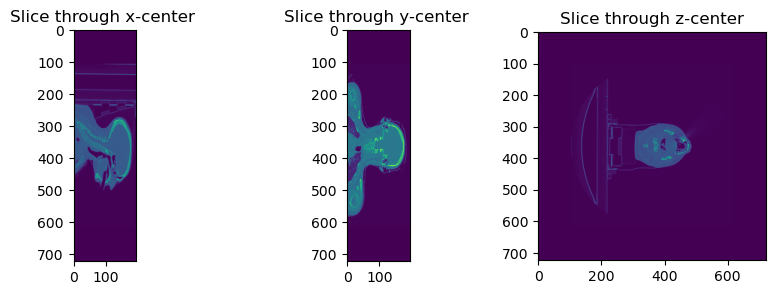

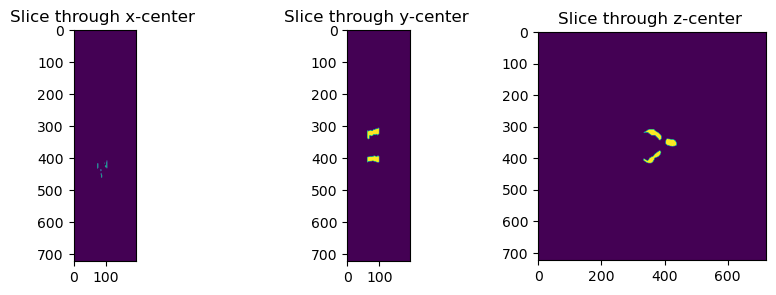

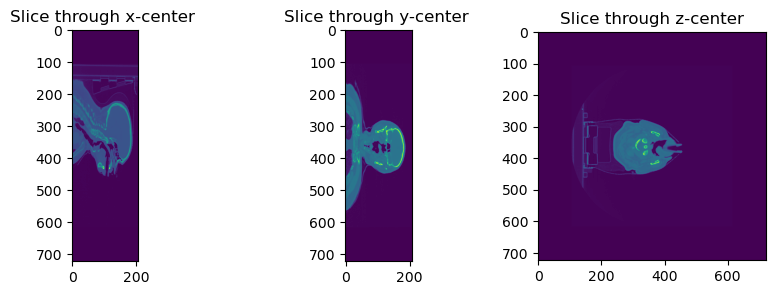

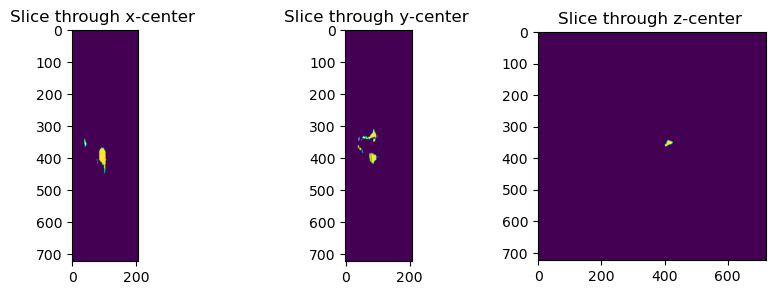

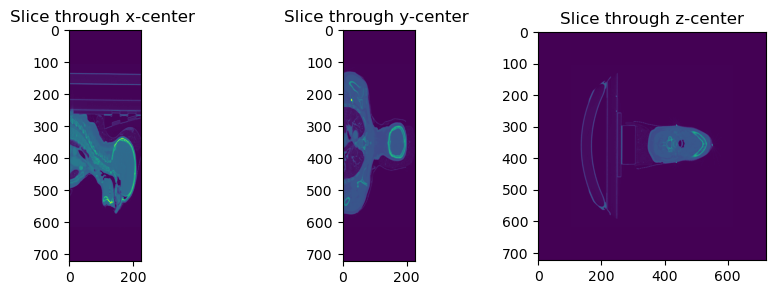

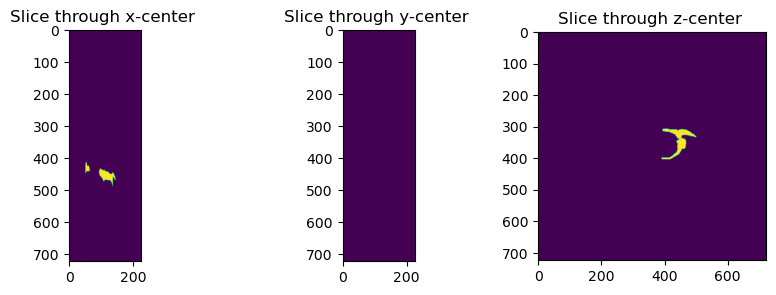

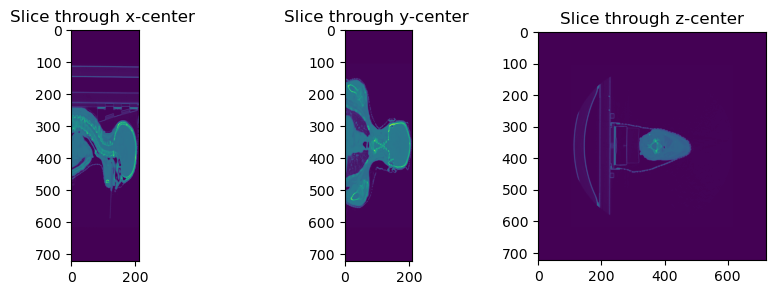

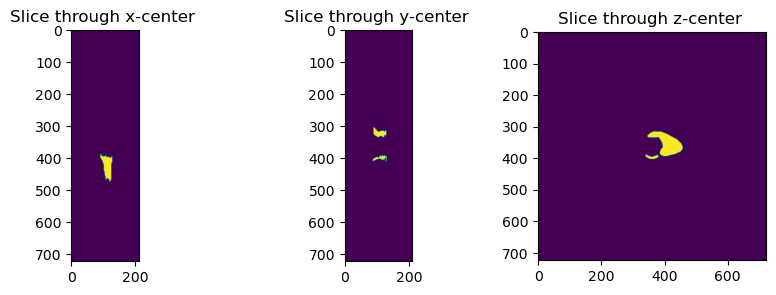

In [6]:
from nilearn import image

image_path = 'results/transformed_results/transformed_images'
label_path = 'results/transformed_results/transformed_labels'
for index in range(len(data_dicts)):
    a, b, c = 0.0, 0.0, 180.0
    img_str = data_dicts[index]['image'].strip("data/imagesTs/").strip(".nii.gz")
    lbl_str = data_dicts[index]['image'].strip("data/imagesTs/").strip("_0000.nii.gz")
    img_path = image_path + "/" + f'{a}_{b}_{c}' + "/"+ img_str + "/" + img_str + f"_rotated_image_{a}_{b}_{c}_0000" + '.nii.gz'
    lbl_path = label_path + "/" + f'{a}_{b}_{c}' + "/"+lbl_str + "/" + lbl_str + f"_rotated_label_{a}_{b}_{c}" + '.nii.gz'
    after_rot = image.load_img(img_path)
    after_rot_label = image.load_img(lbl_path)
    dimension = after_rot.shape

    center = np.divide(dimension,2)
    x_cen = int(np.ceil(center[0]))
    y_cen = int(np.ceil(center[1]))
    z_cen = int(np.ceil(center[2]))

    fig = plt.figure("visualize", (len(data_dicts), 3))
    fig.set_size_inches(10,3)
    plt.subplot(1, 3, 1)
    plt.title(f"Slice through x-center ")
    plt.imshow(get_data(after_rot)[x_cen, :, :])
    plt.subplot(1, 3, 2)
    plt.title(f"Slice through y-center ")
    plt.imshow(get_data(after_rot)[:, y_cen, :])
    plt.subplot(1, 3, 3)
    plt.title(f"Slice through z-center")
    plt.imshow(get_data(after_rot)[:, :, z_cen])
    plt.show()

    fig = plt.figure("labels", (len(data_dicts), 3))
    fig.set_size_inches(10,3)
    plt.subplot(1, 3, 1)
    plt.title(f"Slice through x-center ")
    plt.imshow(get_data(after_rot_label)[x_cen, :, :])
    plt.subplot(1, 3, 2)
    plt.title(f"Slice through y-center ")
    plt.imshow(get_data(after_rot_label)[:, y_cen, :])
    plt.subplot(1, 3, 3)
    plt.title(f"Slice through z-center ")
    plt.imshow(get_data(after_rot_label)[:, :, z_cen])
    plt.show()